
# **<center>Machine Learning and Finance </center>**


## <center> Programming Session 7 - LSTM Based Classification Model </center>

<table class="tfo-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://mlfbg.github.io/MachineLearningInFinance/">
    <img src="https://drive.google.com/uc?export=view&id=1gmxxmwCR1WXK0IYtNqvE4QXFleznWqQO" height="50"/>
    Course page</a>
</td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1XSVM57SmUHoZdIlD2hFU3icLbRfNg-_S?usp=sharing"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />Run in Google Colab</a>
  </td>
</table>




The Objective of this session is to create an LSTM based model for news classification. 


The dataset is the BBC news articles (Source: [here](http://mlg.ucd.ie/files/publications/greene06icml.pdf))


Each Text is associated with one of the following categories: 

* tech
* business
* sport
* entertainment
* politics

In [3]:
# Access files from Google Drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Import basic libraries
import matplotlib.pyplot as plt # for plotting 
import numpy as np # for manipulating arrays
import tensorflow as tf # for creating Neural Networks, we will use it to load data
import os 
import pandas as pd
plt.style.use('dark_background') # to adapt the colors to a dark background
from IPython.display import Image # for showing graphs from the lectures

In [6]:
# Change the directory
os.chdir("./gdrive/My Drive/Colab Notebooks/Session_2022/Programming_Session_7")

# 1. Preprocessing the Data

The objective of this session is to load the data and preprocess it into a `(N, T)` tensor:

* `N` is the number of samples.
* `T` is the length of the sequences. 

All the sequences should be of the same length. 

* First, we need to decide what should be the length `T` (another hyperparameter)
* Then, for each sequence:
  * If it's shorter than `T`, the sequence is padded with zeros.
  * If it's longer than `T`, the sequence is truncated.  


<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1GLwOZWrMiprZpN8jijTkLO_GVpgmi9MM"></center>

You can find the data in the following [link](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data). You can then store the file `train.csv` in a directory called `data`. 

The dataset can be found in the folder `data`. The csv file is named `bbc-text.csv`

You will find the following columns:

* `text` contains the news.

* `category` is an element of the following categories: 
  * tech
  * business
  * sport
  * entertainment
  * politics




---
<font color=green>Q1:</font>
<br><font color='green'>
Load the dataframe and call the dataframe `df` and store the elements in the column `text` in a list called `texts`
</font>

---

In [7]:
# path to data
data_dir = os.path.join(os.getcwd(), "data")

# Load the dataframe
df = pd.read_csv(os.path.join(data_dir, "bbc-text.csv"))

In [8]:
df.head(10)

category                                               text
0           tech  tv future in the hands of viewers with home th...
1       business  worldcom boss  left books alone  former worldc...
2          sport  tigers wary of farrell  gamble  leicester say ...
3          sport  yeading face newcastle in fa cup premiership s...
4  entertainment  ocean s twelve raids box office ocean s twelve...
5       politics  howard hits back at mongrel jibe michael howar...
6       politics  blair prepares to name poll date tony blair is...
7          sport  henman hopes ended in dubai third seed tim hen...
8          sport  wilkinson fit to face edinburgh england captai...
9  entertainment  last star wars  not for children  the sixth an...

The following function is used for cleaning the texts:

In [9]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
def clean(texts):
  clean_texts = []
  for sequence in texts:
    # Get the tokens
    words = sequence.split()
    # Keep only the words   
    alphabetic_only = [word for word in words if word.isalpha()]
    # All tokens should be written in lowercase
    lower_case_only = [word.lower() for word in alphabetic_only]
    # Select the stop words from nltk
    stopwords_nltk = set(stopwords.words('english'))
    # Delete the stop words
    cleaned_words = [word for word in lower_case_only if word not in stopwords_nltk]
    # Transform the list of tokens into a long string
    clean_sequence = ' '.join(cleaned_words)
    # Save the result in the list clean_texts
    clean_texts.append(clean_sequence)
  return clean_texts

---
<font color=green>Q2:</font>
<br><font color='green'>
Replace the column `text` with processed texts using the `clean()` function. The new column should be named `text`. 
</font>

---

In [22]:
# Replace the column text with the processed version of it 
df["text"] = clean(df.text.values)

---
<font color=green>Q3:</font>
<br><font color='green'>
Replace the categories in the column `category` of the dataframe `df` with the corresponding indices in the following table:
</font>

---


 

| **category**  | **index** |
|---------------|-----------|
| tech          | 0         |
| business      | 1         |
| sport         | 2         |
| entertainment | 3         |
| politics      | 4         |




In [24]:
# List of labels
list_labels = list(df.category.unique())

In [25]:
list_labels

['tech', 'business', 'sport', 'entertainment', 'politics']

In [26]:
# Replace the categories with the indices
# df.category.replace({"tech": 0, 
#                      "business" : 1, 
#                      "sport" : 2,
#                      "entertainment": 3,
#                      "politics": 4}, inplace=True)
df.category.replace(list_labels, np.arange(len(list_labels)), inplace=True)

---
<font color=green>Q4:</font>
<br><font color='green'>
Define a list, called `labels` containing the targets associated with each text in the column `text`.
</font>

---

In [27]:
df.head(10)

category                                               text
0         0  tv future hands viewers home theatre systems p...
1         1  worldcom boss left books alone former worldcom...
2         2  tigers wary farrell gamble leicester say rushe...
3         2  yeading face newcastle fa cup premiership side...
4         3  ocean twelve raids box office ocean twelve cri...
5         4  howard hits back mongrel jibe michael howard s...
6         4  blair prepares name poll date tony blair likel...
7         2  henman hopes ended dubai third seed tim henman...
8         2  wilkinson fit face edinburgh england captain j...
9         3  last star wars children sixth final star wars ...

In [28]:
# List of possible labels
labels = df["category"].values

---
<font color=green>Q5:</font>
<br><font color='green'>
Preprocess the texts in the column `text` and transform them into sequences of integers:

* Use `Tokenizer` from `tensorflow.keras.preprocessing.text` to create your tokenizer
* Create your word_index dictionary
* Transform your texts into sequences of integers via your word_index dictionary. 
</font>

---

In [32]:
# Import Modules
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# Set Hyperparameters: Vocabulary size
V = 10000

# Import Modules
from tensorflow.keras.preprocessing.text import Tokenizer

# Select the texts from the column "text"
texts = df["text"].values

# Create the Tokenizer
tokenizer = Tokenizer(num_words=V) # Filter some elements + oov_token (TO DO)

# Fit the tokenizer on the texts to create the word_index dictionary
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


# From texts to sequences of integers 
sequences = tokenizer.texts_to_sequences(texts)

Found 26149 unique tokens.


---
<font color=green>Q6:</font>
<br><font color='green'>
Using `pad_sequences` from `tensorflow.keras.preprocessing.sequence`, transform the list of sequences into an $(N, T)$ tensor called `data`. (Set `T = 300`) 
</font>

---

In [ ]:
# Set hyperparameters
T = 300

# Import Module
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pad sequences
data = pad_sequences(sequences, maxlen= T)

---
<font color=green>Q7:</font>
<br><font color='green'>
Shuffle the rows of the $(N, T)$ tensor `data`. Then, Split the data into training data (80% of data) and test data. Finally, use the one hot encoding process to transform the targets into $(N_1, K)$ and $(N_2, K)$ tensors (where $N_1$ is the size of the training data, $N_2$ the size of the test data and $K$ the number of possible categories.  
</font>

---

In [ ]:
# Shuffle indices
indices = np.arange(len(data))
np.random.shuffle(indices)

# New data
data = data[indices]

# New labels
labels = labels[indices]
print('Shape of data tensor:', data.shape)

Shape of data tensor: (2225, 300)


In [ ]:
# Split 
split = int(.8 * len(texts))
train_data = data[:split]
train_labels = labels[:split]

test_data = data[split:]
test_labels = labels[split:]

In [ ]:
# One hot encoding applied to the targets
from tensorflow.keras.utils import to_categorical


train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

# 2. Creating the Embedding Matrix

## 2.1 Creating the Embedding index dictionary

The objective of this section is to load a pretrained embedding matrix

We introduced the **Word2vec** algorithm in the coursework. 

Let us use the **Glove** pre-trained vectors for this session. 

Its developers have made available precomputed embeddings for millions of English tokens, trained on different corpora like the Wikipedia corpus. 

For more informations, see the link [here](https://nlp.stanford.edu/projects/glove)

Q5. 



---
<font color=green>Q8:</font>
<br><font color='green'>
Run the following code to download the precomputed embeddings from 2014 English Wikipedia. It’s an 822 MB zip file called glove.6B.zip, containing different D-dimensional embedding vectors for 400,000 words (or nonword tokens). Unzip it and store in the folder named `glove.6B`.
</font>

---

In [ ]:
# Download the zip file
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2022-05-31 01:24:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-31 01:24:36--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-31 01:24:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
# Unzip it and put the files in the destination folder `glove.6B`
!unzip glove*.zip -d glove.6B 

---
<font color=green>Q9:</font>
<br><font color='green'>
Create a dictionary called `embedding_index` that maps each word to a vector of size 200 as shown in the following figure:
</font>

---

<center><img width=“1000" src = "https://drive.google.com/uc?export=view&id=1fUAxpg7IU-bYQgntkV6YghOCqTVGwSt1"></center>

In [ ]:
# Directory of the Embedding file
dir_glove = os.path.join(os.getcwd(),'glove.6B')

# Create the dictionary
embedding_index = {}

f = open(os.path.join(dir_glove, "glove.6B.200d.txt"), encoding = "utf8")
for line in f:
    # Split each line
    values = line.split()
    # Get the word
    word = values[0]
    # Get the embedding vector 
    embedding_vector = np.asarray(values[1:], dtype = "float32")
    # Append the dictionary
    embedding_index[word] = embedding_vector
f.close()

In [ ]:
len(embedding_index)

400000

## 2.2. Creating the Embedding matrix

---
<font color=green>Q10:</font>
<br><font color='green'>
Create a matrix called `embedding_matrix` of shape `(V, D)` where `D` is the embedding dimension and `V` the vocabulary size. 
* In this matrix, the row number k will be represented by the embedding vector associated with the word of index k in the `embedding_index` dictionary. 
* If the word of index k is not in the `embedding_index` dictionary, we represent it by a vector of zeros in the embedding matrix. 
</font>

---

<center><img width=“300" src = "https://drive.google.com/uc?export=view&id=1KM1n5qSajHkf4ItxycCddcjq2MhkSS8e"></center>

In [ ]:
# The embedding dimension
D = 200

# Initilize the embedding matrix with zeros
embedding_matrix = np.zeros((V, D))

# Loop through all the elements of the word_index dictionary 
for word, i in word_index.items():
    if i < V:
        # Get the embedding vector or None 
        embedding_vector = embedding_index.get(word) 
        # Update one row of the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# 3. Creating the Model

## 3.1 Using pre-trained word vectors (embedding_matrix) from GloVe

---
<font color=green>Q11:</font>
<br><font color='green'>
Using `Embedding` from `tensorflow.keras.layers`, create the embedding layer called `embedding_layer`

* This layer transforms an `(N, T)` tensor of integers into an `(N, T, D)` tensor.
* Load the `embedding_matrix` into the `embedding_layer`
</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1EdfK87ayAWSEXfr-A60JbXxBuXqd-QL0"></center>

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
  V,
  D,
  weights=[embedding_matrix],
  input_length=T,
  trainable=False
)

---
<font color=green>Q12:</font>
<br><font color='green'>
Create the following model:
</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1ybUjIhriRWlMeTtn2NBiMzPXIQuTRZY3"></center>

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding

# Set hyperparameters
d_1 = 32 # output dimension of the first LSTM layer
d_2 = 32 # output dimension of the second LSTM layer
K = 5 # Output dimension of the last layer 

# Define the two lstm layers
embedding = Embedding(V, D, input_length=T, name = "Embedding_layer")
lstm_1 = LSTM(d_1, return_sequences = True, name = "LSTM_1_layer")
lstm_2 = LSTM(d_2, return_sequences = False, name = "LSTM_2_layer")
dense_layer = Dense(K, activation = "softmax", name = "Dense_layer")


# The input tensor
input_tensor = Input(shape=(T,), dtype = "int32") # (N, T)

# Apply the embeddin lyer
#x = embedding_layer(input_tensor) # (N, T, D)
x = embedding(input_tensor) # (N, T, D)

# Apply the first LSTM layer
y = lstm_1(x) # (N, T, d_1)

# Apply the second LSTM layer
h_T = lstm_2(y) # (N, d_2)

# Apply the dense layer 
output = dense_layer(h_T) # (N, K)

# Define the model
model = Model(input_tensor, output)
model.summary(line_length = 100)

Model: "model_1"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_2 (InputLayer)                        [(None, 300)]                           0              
                                                                                                    
 Embedding_layer (Embedding)                 (None, 300, 200)                        2000000        
                                                                                                    
 LSTM_1_layer (LSTM)                         (None, 300, 32)                         29824          
                                                                                                    
 LSTM_2_layer (LSTM)                         (None, 32)                              8320           
                                                                          

---
<font color=green>Q13:</font>
<br><font color='green'>
Compile your model by using **Adam** algorithm for the optimization instead of Stochastic Gradient Descent (See the following [link](https://arxiv.org/pdf/1412.6980.pdf)). Define different evaluation metrics (Accuracy, precision, recall)
</font>

---



Adam is a modern adaptive learning rate technique, often considered as the default algorithm for many DL practitioners. It combines the idea of **momentum** and **adaptive learning rate** as shown in the following figure:



<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1IsjiRu3oMiRmky0AgZyr_sl97LqqJtOj"></center>

In [ ]:
METRICS = [
    #tf.keras.metrics.Accuracy(name='accuracy'),
    "accuracy",
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
]

In [ ]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

---
<font color=green>Q14:</font>
<br><font color='green'>
Fit your model to the training data. 
* Use `EarlyStopping` from `tensorflow.keras.callbacks` to stop the training when the accuracy doesn't improve.

* Use `ReduceLROnPlateau` from `tensorflow.keras.callbacks` to reduce the learning rate when the validation loss doesn't improve 

* Use `ModelCheckpoint` from `tensorflow.keras.callbacks` to save the best version of the model in a folder called `model`
</font>

---

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
checkpoint_filepath = os.path.join(os.getcwd(), "model")

callbacks_list = [
                  EarlyStopping( # Interrupt the training when there is no more improvement
                      monitor = "val_accuracy", # Metric to monitor
                      patience = 10 # Number of epochs before interrupting the training if there is no improvement
                  ),
                  ModelCheckpoint(
                      filepath = checkpoint_filepath, # path to the destination model file
                      monitor = "val_loss", # metric to monitor
                      save_best_only = True # Keep the best model
                  ),
                  ReduceLROnPlateau(
                      monitor = "val_loss", # metric to monitor
                      factor = 0.1, # Multiply the lr by factor when triggered
                      patience = 10 # Number of epochs of non improvement before the callback is triggered
                  )
]

In [ ]:
history = model.fit(train_data, 
                    train_labels, 
                    epochs = 200, 
                    batch_size=256, 
                    callbacks = callbacks_list,
                    validation_split=.2)

Epoch 1/200
6/6 [==============================] - ETA: 0s - loss: 1.6042 - accuracy: 0.3097 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 19s 3s/step - loss: 1.6042 - accuracy: 0.3097 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5923 - val_accuracy: 0.4326 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - ETA: 0s - loss: 1.5648 - accuracy: 0.4565 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 1.5648 - accuracy: 0.4565 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5485 - val_accuracy: 0.4466 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - ETA: 0s - loss: 1.4588 - accuracy: 0.4740 - precision: 0.0000e+00 - recall: 0.0000e+00

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 15s 3s/step - loss: 1.4588 - accuracy: 0.4740 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4041 - val_accuracy: 0.4888 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - ETA: 0s - loss: 1.2140 - accuracy: 0.4726 - precision: 0.9776 - recall: 0.1531

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 1.2140 - accuracy: 0.4726 - precision: 0.9776 - recall: 0.1531 - val_loss: 1.1364 - val_accuracy: 0.4888 - val_precision: 0.8280 - val_recall: 0.2163 - lr: 0.0010
Epoch 5/200
6/6 [==============================] - ETA: 0s - loss: 0.9899 - accuracy: 0.4874 - precision: 0.8714 - recall: 0.2521

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 13s 2s/step - loss: 0.9899 - accuracy: 0.4874 - precision: 0.8714 - recall: 0.2521 - val_loss: 1.0184 - val_accuracy: 0.5028 - val_precision: 0.8931 - val_recall: 0.3287 - lr: 0.0010
Epoch 6/200
6/6 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.6973 - precision: 0.9795 - recall: 0.4698

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.7643 - accuracy: 0.6973 - precision: 0.9795 - recall: 0.4698 - val_loss: 0.8239 - val_accuracy: 0.8006 - val_precision: 0.9551 - val_recall: 0.4775 - lr: 0.0010
Epoch 7/200
6/6 [==============================] - ETA: 0s - loss: 0.5390 - accuracy: 0.9642 - precision: 0.9980 - recall: 0.7184

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.5390 - accuracy: 0.9642 - precision: 0.9980 - recall: 0.7184 - val_loss: 0.6351 - val_accuracy: 0.8596 - val_precision: 0.9257 - val_recall: 0.6994 - lr: 0.0010
Epoch 8/200
6/6 [==============================] - ETA: 0s - loss: 0.3602 - accuracy: 0.9867 - precision: 0.9976 - recall: 0.8596

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 13s 2s/step - loss: 0.3602 - accuracy: 0.9867 - precision: 0.9976 - recall: 0.8596 - val_loss: 0.4945 - val_accuracy: 0.9101 - val_precision: 0.9388 - val_recall: 0.8624 - lr: 0.0010
Epoch 9/200
6/6 [==============================] - ETA: 0s - loss: 0.2373 - accuracy: 0.9965 - precision: 0.9986 - recall: 0.9944

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.2373 - accuracy: 0.9965 - precision: 0.9986 - recall: 0.9944 - val_loss: 0.4036 - val_accuracy: 0.9270 - val_precision: 0.9312 - val_recall: 0.9129 - lr: 0.0010
Epoch 10/200
6/6 [==============================] - ETA: 0s - loss: 0.1686 - accuracy: 0.9965 - precision: 0.9972 - recall: 0.9965

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.1686 - accuracy: 0.9965 - precision: 0.9972 - recall: 0.9965 - val_loss: 0.3821 - val_accuracy: 0.9129 - val_precision: 0.9127 - val_recall: 0.9101 - lr: 0.0010
Epoch 11/200
6/6 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.1245 - accuracy: 0.9979 - precision: 0.9979 - recall: 0.9979 - val_loss: 0.3720 - val_accuracy: 0.9157 - val_precision: 0.9205 - val_recall: 0.9101 - lr: 0.0010
Epoch 12/200
6/6 [==============================] - ETA: 0s - loss: 0.1016 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9958

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 13s 2s/step - loss: 0.1016 - accuracy: 0.9965 - precision: 0.9965 - recall: 0.9958 - val_loss: 0.3413 - val_accuracy: 0.9185 - val_precision: 0.9235 - val_recall: 0.9157 - lr: 0.0010
Epoch 13/200
6/6 [==============================] - ETA: 0s - loss: 0.0766 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.0766 - accuracy: 0.9993 - precision: 0.9993 - recall: 0.9993 - val_loss: 0.3350 - val_accuracy: 0.9129 - val_precision: 0.9129 - val_recall: 0.9129 - lr: 0.0010
Epoch 14/200
6/6 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9979

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 14s 3s/step - loss: 0.0652 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9979 - val_loss: 0.3039 - val_accuracy: 0.9298 - val_precision: 0.9298 - val_recall: 0.9298 - lr: 0.0010
Epoch 15/200
6/6 [==============================] - 6s 941ms/step - loss: 0.0552 - accuracy: 0.9986 - precision: 0.9993 - recall: 0.9986 - val_loss: 0.3576 - val_accuracy: 0.9157 - val_precision: 0.9209 - val_recall: 0.9157 - lr: 0.0010
Epoch 16/200
6/6 [==============================] - 6s 925ms/step - loss: 0.0499 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - val_loss: 0.3630 - val_accuracy: 0.9129 - val_precision: 0.9129 - val_recall: 0.9129 - lr: 0.0010
Epoch 17/200
6/6 [==============================] - 6s 932ms/step - loss: 0.0399 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.3647 - val_accuracy: 0.9129 - val_precision: 0.9181 - val_recall: 0.9129 - lr: 0.0010
Epoch 18/200
6/6 [==============================] - 6s 936ms/step -

---
<font color=green>Q15:</font>
<br><font color='green'>
Test your model on the test data 
</font>

---

In [ ]:
# Evaluate the model 
model.evaluate(test_data, test_labels)
# model.predict(test_data) -> predictions -> compare predictions (N_test, K) with test_labels (N_test, K)

14/14 [==============================] - 1s 56ms/step - loss: 0.2133 - accuracy: 0.9461 - precision: 0.9461 - recall: 0.9461


[0.2132977396249771,
 0.9460673928260803,
 0.9460673928260803,
 0.9460673928260803]

---
<font color=green>Q16:</font>
<br><font color='green'>
Plot the training and validation loss
</font>

---

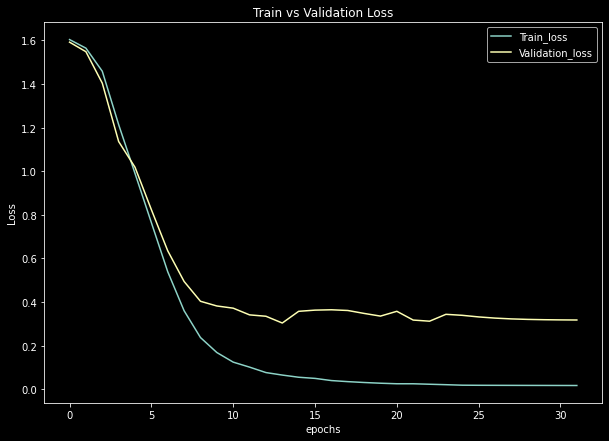

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["loss"], label = "Train_loss")
plt.plot(history.history["val_loss"], label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

---
<font color=green>Q17:</font>
<br><font color='green'>
Plot the training and validation accuracy
</font>

---

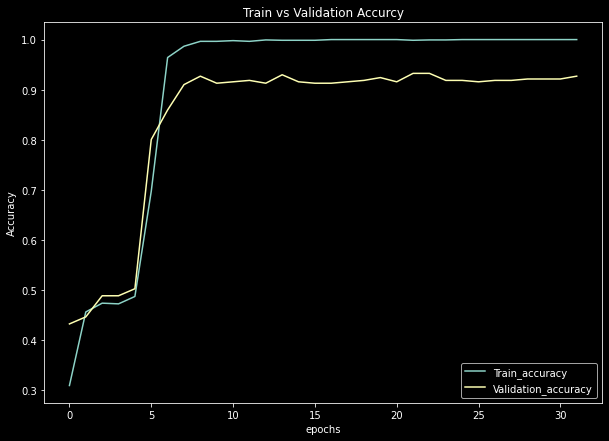

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["accuracy"], label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

---
<font color=green>Q18:</font>
<br><font color='green'>
Plot the training and validation precision
</font>

---

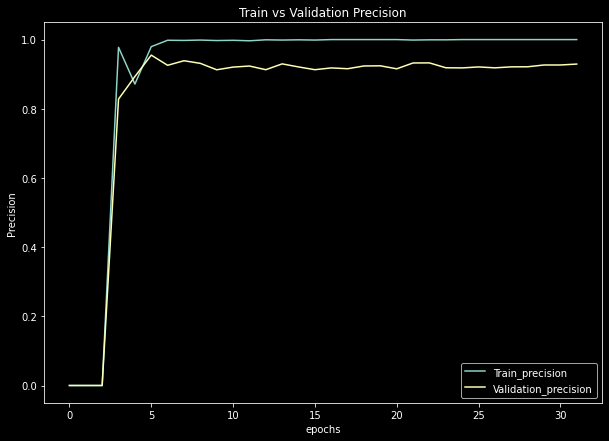

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["precision"], label = "Train_precision")
plt.plot(history.history["val_precision"], label = "Validation_precision")
plt.xlabel("epochs")
plt.ylabel("Precision")
plt.title("Train vs Validation Precision")
plt.legend()
plt.show()

---
<font color=green>Q19:</font>
<br><font color='green'>
Plot the training and validation recall
</font>

---

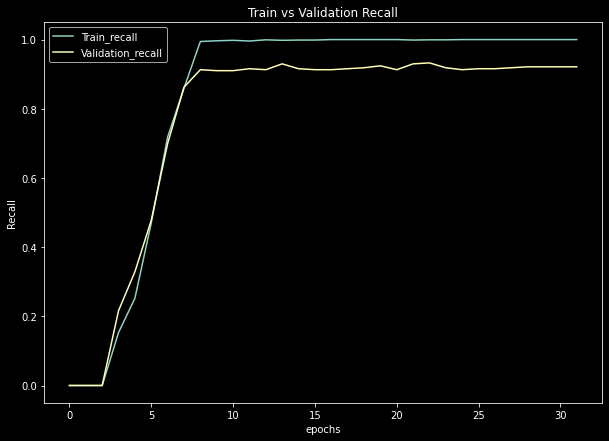

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["recall"], label = "Train_recall")
plt.plot(history.history["val_recall"], label = "Validation_recall")
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.title("Train vs Validation Recall")
plt.legend()
plt.show()

---
<font color=green>Q20:</font>
<br><font color='green'>
Plot the confusion matrix using the following function
</font>

---

In [ ]:
# Import Modules
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Functin to plot the confusion matrix
def plot_confusion_matrix(y_test, y_hat):
  fig = plt.figure(figsize=(10, 8))
  g = sns.heatmap(confusion_matrix(y_test, y_hat),
              annot=True,
              fmt="0.0f")
  g.set_xlabel("Predicted")
  g.set_ylabel("Actual")
  g.set_title("Confusion Matrix on the test set")
  plt.show()

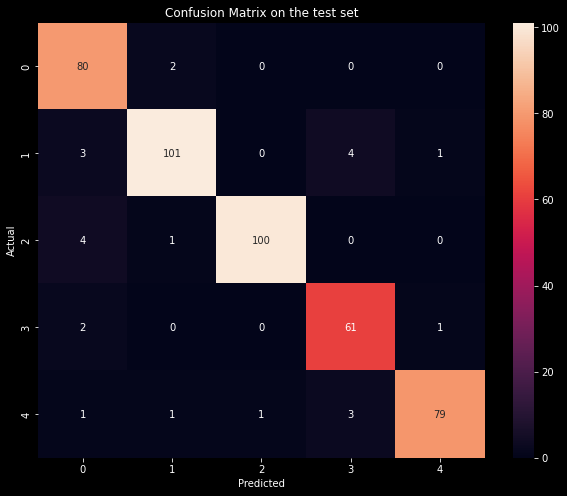

In [ ]:
# Get the prediction in the (N, K) shape
prediction = model.predict(test_data)

# Transform it into the shape (N,)
y_pred = np.argmax(prediction, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)


## 3.2 Training the embedding matrix

---
<font color=green>Q20:</font>
<br><font color='green'>
Create the following model
</font>

---

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1FXc2jWEuuodqtu68Qeac33_V6J-mE__n"></center>

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense 

# Set hyperparameters
d_1 = 32 # output dimension of the first LSTM layer
d_2 = 32 # output dimension of the second LSTM layer
K = 5 # Output dimension of the last layer 


model = Sequential()
model.add(Embedding(V, D, input_length=T))
model.add(Bidirectional(LSTM(d_1, return_sequences = False)))
model.add(Dense(K, activation = "softmax"))
model.summary(line_length=150)

Model: "sequential"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 embedding_1 (Embedding)                                           (None, 300, 200)                                            2000000                
                                                                                                                                                      
 bidirectional (Bidirectional)                                     (None, 64)                                                  59648                  
                                                                                                                                                      
 dense (Dense)                                                     (None, 

---
<font color=green>Q21:</font>
<br><font color='green'>
Fit your new model to the training data. Plot the tranining and validation loss,accuracy, precision and recall. Then, evaluate your model on the test data
</font>

---

In [ ]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

history = model.fit(train_data, 
                    train_labels, 
                    epochs = 200, 
                    batch_size=256, 
                    callbacks = callbacks_list,
                    validation_split=.2)

Epoch 1/200
6/6 [==============================] - 12s 2s/step - loss: 1.5973 - accuracy: 0.2753 - precision: 0.9461 - recall: 0.2253 - val_loss: 1.5845 - val_accuracy: 0.4045 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 2/200
6/6 [==============================] - 8s 1s/step - loss: 1.5616 - accuracy: 0.4712 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5614 - val_accuracy: 0.4466 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 3/200
6/6 [==============================] - 8s 1s/step - loss: 1.5099 - accuracy: 0.5147 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.5142 - val_accuracy: 0.4860 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 4/200
6/6 [==============================] - 8s 1s/step - loss: 1.4139 - accuracy: 0.6440 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.4135 - val_accuracy: 0.6236 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 0.0010
Epoch 5/200

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 19s 4s/step - loss: 0.0597 - accuracy: 0.9986 - precision: 0.9986 - recall: 0.9986 - val_loss: 0.2602 - val_accuracy: 0.9410 - val_precision: 0.9513 - val_recall: 0.9326 - lr: 0.0010
Epoch 23/200
6/6 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 20s 4s/step - loss: 0.0529 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2439 - val_accuracy: 0.9494 - val_precision: 0.9573 - val_recall: 0.9438 - lr: 0.0010
Epoch 24/200
6/6 [==============================] - ETA: 0s - loss: 0.0493 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9993

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 20s 4s/step - loss: 0.0493 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9993 - val_loss: 0.2417 - val_accuracy: 0.9522 - val_precision: 0.9547 - val_recall: 0.9466 - lr: 0.0010
Epoch 25/200
6/6 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9993

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 19s 4s/step - loss: 0.0450 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9993 - val_loss: 0.2351 - val_accuracy: 0.9522 - val_precision: 0.9547 - val_recall: 0.9466 - lr: 0.0010
Epoch 26/200
6/6 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 20s 4s/step - loss: 0.0410 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2308 - val_accuracy: 0.9522 - val_precision: 0.9520 - val_recall: 0.9466 - lr: 0.0010
Epoch 27/200
6/6 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000

INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/Colab Notebooks/Session_2022/Programming_Session_7/model/assets


6/6 [==============================] - 20s 4s/step - loss: 0.0376 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2193 - val_accuracy: 0.9551 - val_precision: 0.9549 - val_recall: 0.9522 - lr: 0.0010
Epoch 28/200
6/6 [==============================] - 8s 1s/step - loss: 0.0347 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2452 - val_accuracy: 0.9494 - val_precision: 0.9521 - val_recall: 0.9494 - lr: 0.0010
Epoch 29/200
6/6 [==============================] - 8s 1s/step - loss: 0.0340 - accuracy: 0.9993 - precision: 1.0000 - recall: 0.9993 - val_loss: 0.2651 - val_accuracy: 0.9410 - val_precision: 0.9433 - val_recall: 0.9354 - lr: 0.0010
Epoch 30/200
6/6 [==============================] - 8s 1s/step - loss: 0.0303 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 0.2751 - val_accuracy: 0.9270 - val_precision: 0.9429 - val_recall: 0.9270 - lr: 0.0010
Epoch 31/200
6/6 [==============================] - 8s 1s/step - loss: 0.027

In [ ]:
# Evaluate the model 
model.evaluate(test_data, test_labels)

14/14 [==============================] - 1s 64ms/step - loss: 0.2122 - accuracy: 0.9506 - precision: 0.9548 - recall: 0.9483


[0.2121778279542923,
 0.9505618214607239,
 0.9547511339187622,
 0.9483146071434021]

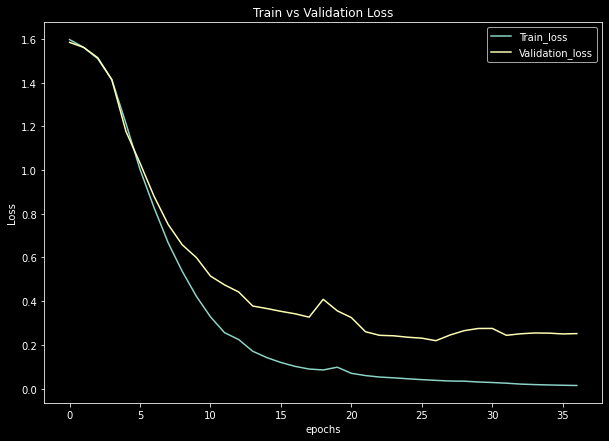

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["loss"], label = "Train_loss")
plt.plot(history.history["val_loss"], label = "Validation_loss")
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.show()

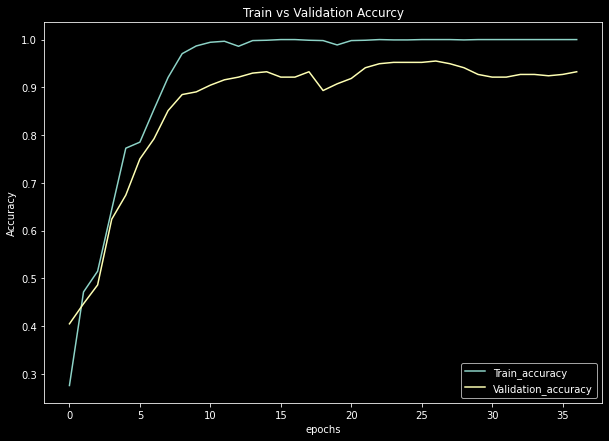

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["accuracy"], label = "Train_accuracy")
plt.plot(history.history["val_accuracy"], label = "Validation_accuracy")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accurcy")
plt.legend()
plt.show()

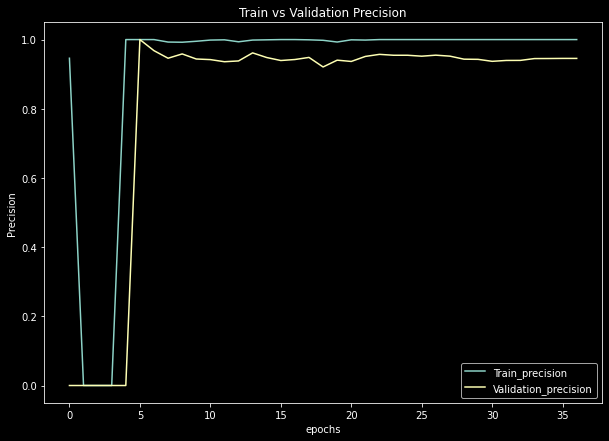

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["precision"], label = "Train_precision")
plt.plot(history.history["val_precision"], label = "Validation_precision")
plt.xlabel("epochs")
plt.ylabel("Precision")
plt.title("Train vs Validation Precision")
plt.legend()
plt.show()

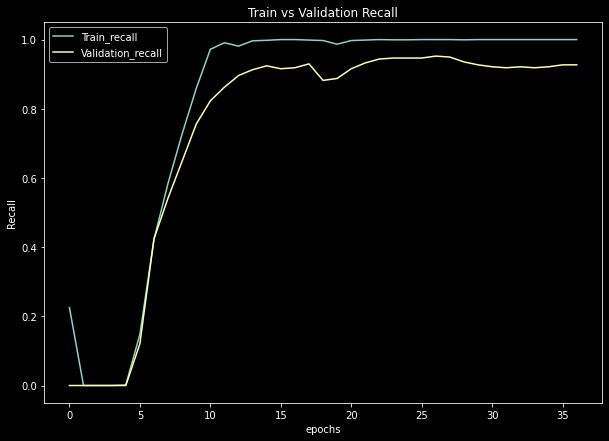

In [ ]:
figure = plt.figure(figsize = (10, 7))
plt.plot(history.history["recall"], label = "Train_recall")
plt.plot(history.history["val_recall"], label = "Validation_recall")
plt.xlabel("epochs")
plt.ylabel("Recall")
plt.title("Train vs Validation Recall")
plt.legend()
plt.show()

---
<font color=green>Q21:</font>
<br><font color='green'>
Plot the confusion matrix
</font>

---

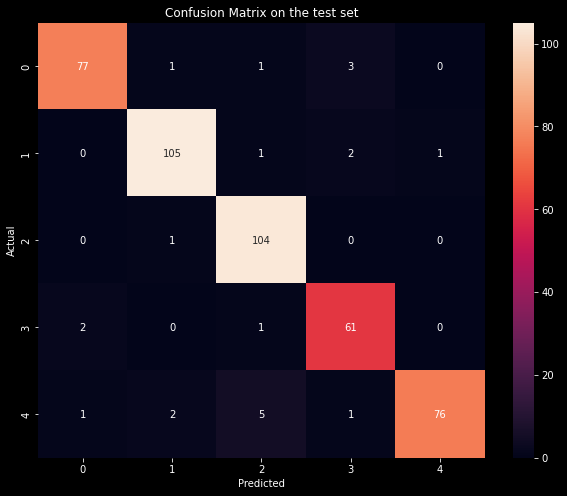

In [ ]:
# Get the prediction in the (N, K) shape
prediction = model.predict(test_data)

# Transform it into the shape (N,)
y_pred = np.argmax(prediction, axis=1)
y_true = np.argmax(test_labels, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)

# Wrap-up

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1UZuzjojifkjy8BaLXejXYwGCjzL4DJua"></center>

## To go further...

As an exercise:

* Change the hyperparameters and add some regularization to have the same performance on the training dataset and the test dataset.

* Test different architectures on another dataset, stored in the folder "data": `news_headlines.csv`. This dataset contains the sentiments for financial news headlines from the perspective of a retail investor. Further details about the dataset can be found in: [Malo, P., Sinha, A., Takala, P., Korhonen, P. and Wallenius, J. (2014): “Good debt or bad debt: Detecting semantic orientations in economic texts.](https://arxiv.org/pdf/1307.5336.pdf) 

## Introducing the next lecture

LSTM layers can be used to tackle a wide range of problems:

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1lB5wkfX66shxrymtQNfszXdKO8qjSD6h"></center>

For Many to many problems when the length of the input sequence is different from the length of the output sequence, we use the following architecture decribed in the following paper: [Sequence to Sequence Learning
with Neural Networks](https://papers.nips.cc/paper/5346-sequence-to-sequence-learning-with-neural-networks.pdf):

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1SASHthGKMVBvlU0CcXX5Rfg0WYny4fS2"></center>

As seq2seq architecture don't handle very well long sentences, we use **Attention**, which aims at looking on a context in the input and weight it correctly to generate the output. 

A good reference for it : [Attention Is All You Need](https://arxiv.org/pdf/1706.03762v5.pdf)

An example of application in Speech Recognition:

<center><img width=“700" src = "https://drive.google.com/uc?export=view&id=1QkTzmlvA2OVVwnM0x91bVDd7CeVH7PlL"></center>:

### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk

